In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
import pickle

# import parameters
from cifar10_params import *

"""
loading vae model back is not a straight-forward task because of custom loss layer.
we have to define some architecture back again to specify custom loss layer and hence to load model back again.
"""

# tensorflow or theano
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# load saved models
#vae = keras.models.load_model('./models/cifar10_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
#    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
#encoder = keras.models.load_model('./models/cifar10_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
#    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
generator = keras.models.load_model('./models/cifar10_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})

# load history if saved
fname = './models/cifar10_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
try:
    with open(fname, 'rb') as fo:
        history = pickle.load(fo)
    # print(history)
except:
    print("training history not saved")



# load dataset to plot latent space
(x_train, _), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

if latent_dim == 3:
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
    plt.show()

if latent_dim == 2:
    # display a 2D plot of the classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

"""
# display a 2D manifold of the images
n = 15  # figure with 15x15 images
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
"""

# display images generated from randomly sampled latent vector
n = 15
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.imsave('vae_cifar-10.png',figure)
plt.show()

print(epochs)

c:\users\d065042\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\d065042\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1200


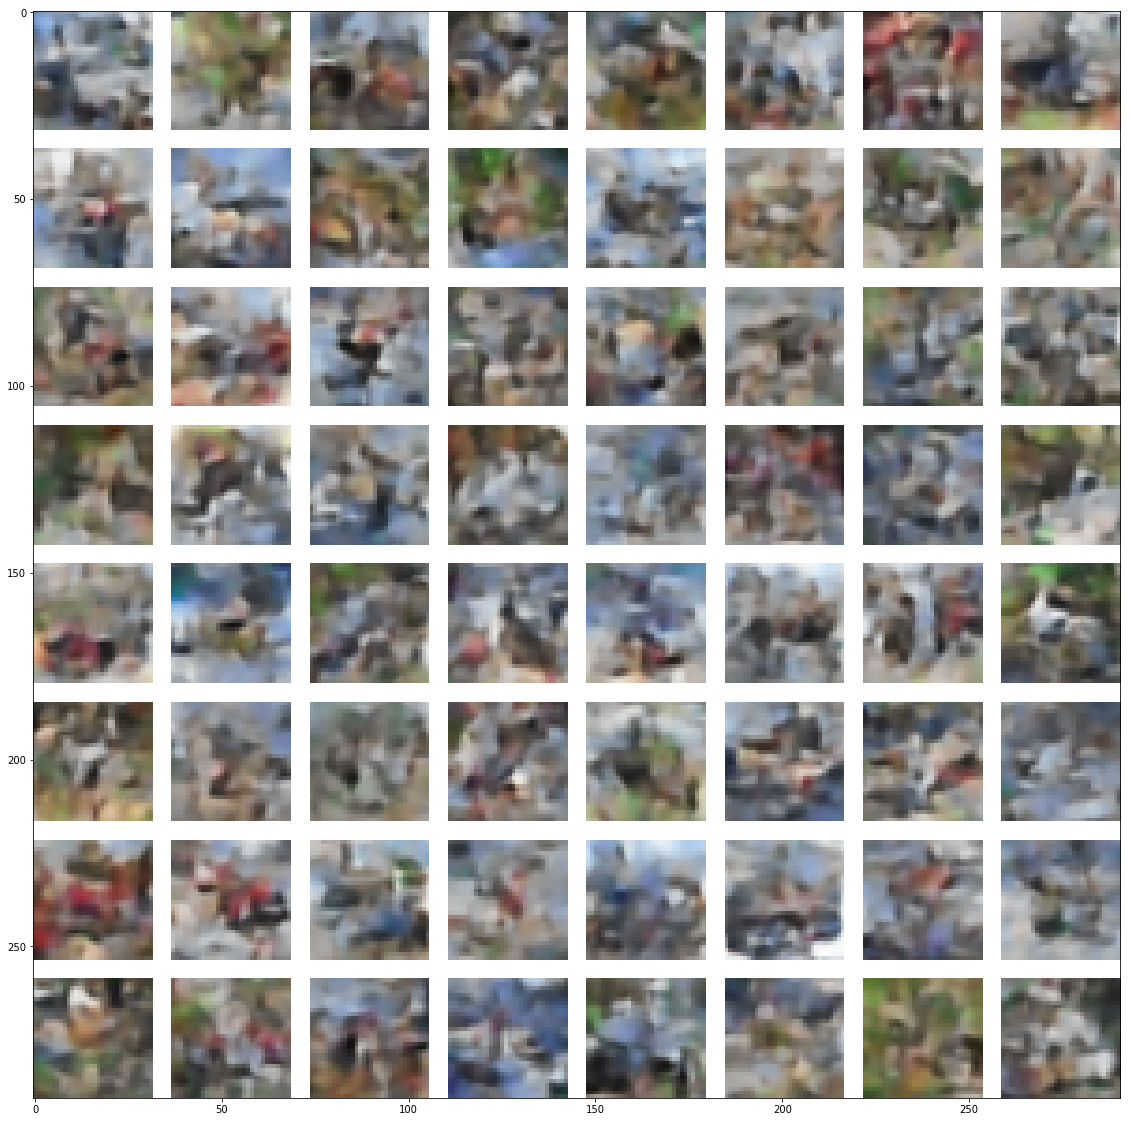

In [3]:
save_img([8,8])

In [2]:
def save_img(size, pad=5):

    figure = np.ones((32 * size[0] + (size[0]-1)*pad, 32 * size[1] + (size[1]-1)*pad, 3))

    for i in range(size[0]):
        for j in range(size[1]):
            z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
            x_decoded = generator.predict(z_sample)
            img = x_decoded[0].reshape(img_size, img_size, img_chns)
            figure[i * 32 + i*pad: (i + 1) * 32 + i*pad,j * 32 + j*pad: (j + 1) * 32+ j*pad] = img

    plt.figure(figsize=(20, 20))
    plt.imshow(figure)
    plt.imsave('vae_cifar-10.png',figure)
    plt.show()